MOTIVATION

Detailed simulation of qubit-cavity coupling with two-photon sideband transitions to verify the simplified simulation of the cQED atomic beam experiment.

NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator ]
  - Qubit: blue
  - Resonator: red

VALUES
- N = 2
    - Single tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 1.2974 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ 1.2135 * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 5.348 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ 5.177 * 2 * pi
    - Double tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : shift ~ 0.13439 * 2 * pi (min cavity at -0.955573)
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : shift ~ 0.0725 * 2 * pi (n=1 right in between both maxima)
            - wq = 6.5, wc = 4 : shift ~ 0.0730 * 2 * pi (cavity exactly at n=1)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *
from qutip import *
from ipywidgets import widgets
from IPython.display import display

home = "/home/student/thesis/"
options = Options()
options.store_states=True

In [2]:
Nq = 2   # number of levels in qubit
Nc = 10  # number of levels in resonator 1
Nt = 2   # number of drive tones

wq = 6.5 *2*pi     # qubit frequency
wc = 4 *2*pi       # resonator frequency
delta = wq - wc    # detuning
Ec = 0.16 *2*pi    # anharmonicity (charging energy)
g = 0.2 *2*pi      # coupling between qubit and resonator

sb = 'red'  # kind of sideband transitions

if Nt == 1:
    Omega = 0.3 *2 *2*pi  # pump drive amplitude
    wd = 5.348 *2*pi      # pump drive frequency
    Stark_shift = Omega**2/(2*(wq-wd)) + Omega**2/(2*(wq+wd))  # ac-Stark shift
elif Nt == 2:
    Omegaq = 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
    Omegac = 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
    dw = 0.1 *2*pi
    shift = 0.13439 *2*pi  # ac-Stark shift
    
    if sb == 'red':
        wdq =  wq + shift - dw
        wdc =  wc - dw
    elif sb == 'blue':
        wdq =  wq + shift + dw
        wdc =  wc - dw

In [3]:
t0 = 0         # start of simulation
t1 = t0 + 0   # start of drive
t2 = t1 + 50  # end of drive
t3 = t2 + 0   # end of simulation
tg = 10        # length of gaussian rise and fall

smooth = True  # whether or not to rise and fall with gaussian
Q = 3          # number of std's in gaussian rise and fall

Np = 100*int(t3)     # number of discrete time steps for which to store the output
print("timestep =", 1e3*np.round(t3/Np, 5), "ps")

timestep = 10.0 ps


In [4]:
# Operators
b, a, nq, nc = ops(Nq, Nc)

# Jaynes-Cummings Hamiltonian
Hjc = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b
Hc = g*(a*b + a*b.dag() + b*a.dag() + a.dag()*b.dag())

# Sideband transitions
if Nt == 1:
    Hd = Omega*(b + b.dag())
elif Nt == 2:
    Hdq = Omegaq*(b + b.dag())
    Hdc = Omegac*(b + b.dag())

# Hamiltonian arguments
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg,
              'Q'  : Q, 'smooth' : smooth, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg,
              'Q'  : Q, 'smooth' : smooth, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}

# Expectation operators
e_ops = [nq, nc]

In [5]:
if Nt == 1:
    H = [Hjc, [Hc, drive_nonosc], [Hd, drive]]  # complete Hamiltonian
elif Nt == 2:
    H = [Hjc, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec]]  # complete Hamiltonian

if sb == 'red':
    psi0 = tensor(basis(Nq, 1), basis(Nc, 0))  # initial state
elif sb == 'blue':
    psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # initial state

# Select these options for bdf method
options.method = 'bdf'
options.rtol = 1e-10
options.atol = 1e-10

# Select these options for adams method
# options.nsteps = 1000
# options.rtol = 1e-12
# options.atol = 1e-12
# options.max_step = 0

Np_per_batch = Np/100  # number of time points per batch

In [6]:
""" CALCULATE! """

progfolder = calculate(H, psi0, e_ops, H_args, options, Nc, g, Np, Np_per_batch, verbose=True)

# Save parameters
if Nt == 1:
    saveparams(Nq, Nc, Nt, wq, wc, Ec, g, sb, t0, t1, t2, t3, tg, smooth, Q,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'], Omega=Omega, wd=wd)
elif Nt == 2:
    saveparams(Nq, Nc, Nt, wq, wc, Ec, g, sb, t0, t1, t2, t3, tg, smooth, Q,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'],
               Omegaq=Omegaq, Omegac=Omegac, wdq=wdq, wdc=wdc, dw=dw)

1 / 100 : 1 %
2 / 100 : 2 %
3 / 100 : 3 %
4 / 100 : 4 %
5 / 100 : 5 %
6 / 100 : 6 %
7 / 100 : 7 %
8 / 100 : 8 %
9 / 100 : 9 %
10 / 100 : 10 %
11 / 100 : 11 %
12 / 100 : 12 %
13 / 100 : 13 %
14 / 100 : 14 %
15 / 100 : 15 %
16 / 100 : 16 %
17 / 100 : 17 %
18 / 100 : 18 %
19 / 100 : 19 %
20 / 100 : 20 %
21 / 100 : 21 %
22 / 100 : 22 %
23 / 100 : 23 %
24 / 100 : 24 %
25 / 100 : 25 %
26 / 100 : 26 %
27 / 100 : 27 %
28 / 100 : 28 %
29 / 100 : 29 %
30 / 100 : 30 %
31 / 100 : 31 %
32 / 100 : 32 %
33 / 100 : 33 %
34 / 100 : 34 %
35 / 100 : 35 %
36 / 100 : 36 %
37 / 100 : 37 %
38 / 100 : 38 %
39 / 100 : 39 %
40 / 100 : 40 %
41 / 100 : 41 %
42 / 100 : 42 %
43 / 100 : 43 %
44 / 100 : 44 %
45 / 100 : 45 %
46 / 100 : 46 %
47 / 100 : 47 %
48 / 100 : 48 %
49 / 100 : 49 %
50 / 100 : 50 %
51 / 100 : 51 %
52 / 100 : 52 %
53 / 100 : 53 %
54 / 100 : 54 %
55 / 100 : 55 %
56 / 100 : 56 %
57 / 100 : 57 %
58 / 100 : 58 %
59 / 100 : 59 %
60 / 100 : 60 %
61 / 100 : 61 %
62 / 100 : 62 %
63 / 100 : 63 %
64 / 100 :

In [8]:
""" SAVE EVOLUTION TEMPORARILY """

srcfolder =  progfolder#"/home/student/thesis/data_190925_105001_red_Nq2_Nt2_Omq0.05_wdq6.434_Omc0.63_wdc3.8_wq6.5_wc4.0_g0.2_wsb0.0142"
quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0', 'coupling']

start_comb = datetime.now()
new_folder_name = copy(srcfolder)
ID = getID(srcfolder)
combine_batches(srcfolder, quants=quants, return_data=False)
end_comb = datetime.now()
print("Batches combined    in {} s".format((end_comb - start_comb).total_seconds()))

times, states, expect, e0, g1, e1, g0, coupling = load_data(quants, srcfolder)

Batches combined    in 0.463795 s


In [9]:
""" SIDEBAND COUPLING """

smoothen_method = 'savgol'

if 'eo' in quants:
    e0_macro, e0_macro_times = remove_micromotion(e0, times, method=smoothen_method)
if 'go' in quants:
    g0_macro, g0_macro_times = remove_micromotion(g0, times, method=smoothen_method)
if 'e1' in quants:
    e1_macro, e1_macro_times = remove_micromotion(e1, times, method=smoothen_method)
if 'g1' in quants:
    g1_macro, g1_macro_times = remove_micromotion(g1, times, method=smoothen_method)
if ('e1' in quants and 'g0' in quants):
    e1g0_macro, e1g0_macro_times = remove_micromotion(e1-g0, times, method=smoothen_method)
if ('e0' in quants and 'g1' in quants):
    e0g1_macro, e0g1_macro_times = remove_micromotion(e0-g1, times, method=smoothen_method)

if sb == 'red':
    wsb = sideband_freq(e0g1_macro, e0g1_macro_times)
elif sb == 'blue':
    wsb = sideband_freq(e1g0_macro, e1g0_macro_times)

         increase the simulation time


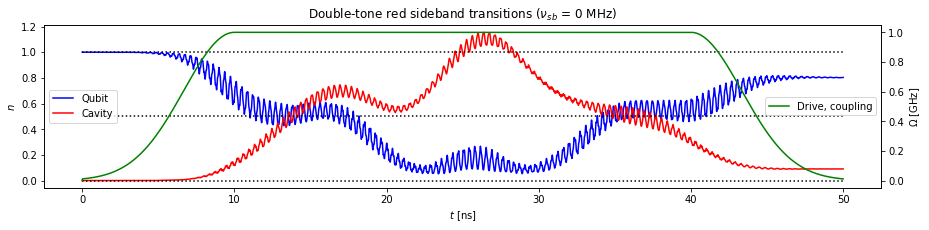

In [13]:
""" EXPECTATION VALUES """

if sb == 'red':
    if Nt == 1:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=None, ylim=None, figsize=[15,3], wd=wd, wsb=wsb)
    elif Nt == 2:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=None, ylim=None, figsize=[15,3], wsb=wsb)
elif sb == 'blue':
    if Nt == 1:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=None, ylim=None, figsize=[15,3], wd=wd, wsb=wsb)
    elif Nt == 2:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=None, ylim=None, figsize=[15,3], wsb=wsb)

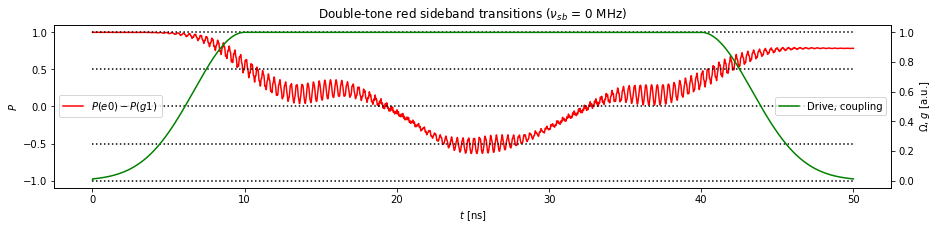

In [14]:
"""COMBINED PROBABILITIES"""

if sb == 'red':
    if Nt == 1:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling,
                                xlim=None, ylim=None, figsize=[15,3], e0=e0, g1=g1, wd=wd, wsb=wsb)
    elif Nt == 2:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling,
                                xlim=None, ylim=None, figsize=[15,3], e0=e0, g1=g1, wsb=wsb)
elif sb == 'blue':
    if Nt == 1:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling,
                                xlim=None, ylim=None, figsize=[15,3], e1=e1, g0=g0, wd=wd, wsb=wsb)
    elif Nt == 2:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling,
                                xlim=None, ylim=None, figsize=[15,3], e1=e1, g0=g0, wsb=wsb)

In [15]:
""" SAVE DATA FOR GOOD """

data_saved = False
data_button = widgets.Button(description='Save data')
data_out = widgets.Output()
def data_clicked(b):
    data_button.description = 'Data saved!'
    with data_out:
        global srcfolder
        if Nt == 1:
            new_folder_name = home + "data_{}_{}_Nq{}_Nt{}_Om{}_wd{}_wq{}_wc{}_g{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(g/2/pi, 2), round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" +
                        "fig_qc_{}_{}_Nq{}_Nt{}_Om{}_wd{}_wq{}_wc{}_g{}_wsb{}.png".format(ID, sb, Nq, Nt,
                        round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
            fig.savefig(srcfolder + "/" +
                        "fig_{}_{}_Nq{}_Nt{}_Om{}_wd{}_wq{}_wc{}_g{}_wsb{}.png".format(ID, sb, Nq, Nt,
                        round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
        elif Nt == 2:
            new_folder_name = home + "data_{}_{}_Nq{}_Nt{}_Omq{}_wdq{}_Omc{}_wdc{}_wq{}_wc{}_g{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(Omegaq/2/pi, 2), round(wdq/2/pi, 3), round(Omegac/2/pi, 2),
                              round(wdc/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2), round(g/2/pi, 2),
                              round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" +
                        "fig_qc_{}_{}_Nq{}_Nt{}_Omq{}_wdq{}_Omc{}_wdc{}_wq{}_wc{}_g{}_wsb{}.png".format(
                        ID, sb, Nq, Nt, round(Omegaq/2/pi, 2), round(wdq/2/pi, 3), round(Omegac/2/pi, 2),
                        round(wdc/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
            fig.savefig(srcfolder + "/" +
                        "fig_{}_{}_Nq{}_Nt{}_Omq{}_wdq{}_Omc{}_wdc{}_wq{}_wc{}_g{}_wsb{}.png".format(
                        ID, sb, Nq, Nt, round(Omegaq/2/pi, 2), round(wdq/2/pi, 3), round(Omegac/2/pi, 2),
                        round(wdc/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
        os.rename(srcfolder, new_folder_name)
        print("Folder renamed to", new_folder_name)
        srcfolder = new_folder_name
data_button.on_click(data_clicked)
widgets.VBox([data_button, data_out])

In [ ]:
"""SCANNING (single tone)"""
# WDs = np.linspace(0.33*2*pi, 0.34*2*pi, 11)  # drive freq range to scan
# for WD in WDs:
#     sample_single_tone(Nq, wq, wc, WD, smooth, Q, t0, t1, t2, t3, tg, psi0, Np_per_batch, options)

In [ ]:
"""SCANNING (double tone)"""
# fshifts = np.linspace(0.13425*2*pi, 0.13445*2*pi, 11)  # ac-Stark shift range to scan
# for fshift in fshifts:
#     sample_double_tone(Nq, wq, wc, fshift, dw, sb, smooth, Q, t0, t1, t2, t3, tg, psi0, Np_per_batch, options)